In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Compute Loss Function

In [63]:
# calculate du^ n / dt^n for arbitrary n and use this to create a loss term
def compute_derivative(u, t, norm_term, num_u_vectors):
    
    # compute derivative of outputs with respect to inputs 
    derivs_list = []
    for i in range(num_u_vectors):
        # individually compute du/dt for each u and combine them all togteher afterwards
        du_dt = torch.autograd.grad(u[:, i, :], t, grad_outputs=torch.ones_like(u[:, i, :]), create_graph=True)[0]
        derivs_list.append(du_dt)

    deriv_to_t = torch.stack(derivs_list, dim=1) 
    
    return deriv_to_t

# build the loss function
def loss(x, A, v, model):
    
    # loss results
    loss_dict = {}
            
    # create the trial solution
    model_result = lambda t: model(t)[0]
    u = model_result(x).unsqueeze(dim=-1)
    
    # determine the number of u vectors
    num_u_vectors = u.shape[1]
        
    # compute A * u
    A_times_u = torch.matmul(A, u)
    
    # compute du/dt (Note: each u is computed separately to avoid torch.autograd.grad() summing them together)
    du_dt = compute_derivative(u, x, 0, num_u_vectors)

    # compute the L_T term
    L_t_term = du_dt + A_times_u
    L_t = torch.matmul(L_t_term.mT, L_t_term)
    
    # compute the L_0 term
    u_0 = model_result(torch.tensor([[0]], dtype=torch.float32))[0].unsqueeze(dim=-1)
    
    L_0_term = u_0 - v
    L_0 = torch.matmul(L_0_term.T, L_0_term)
    
    # compute the overall loss 
    L = torch.mean(L_t) + L_0
    
    # normalize loss and use it to compute the normalization factor
    # norm_term1, norm_term2 = 1 / As[0] ** 2, 1 / As[1] ** 2 ---> these are now 1 / v[0] **2 (I.C.)
    
    loss_dict['L_D'] = L
    loss_dict['L_total'] = L

    return loss_dict

# Build Network

In [56]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size):
        super(BuildNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3) 
        self.output = nn.Linear(h_size3, output_size)
        
    def forward(self, x):
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result)
        result = self.output(h)
        
        return result, h

# Train Model

In [57]:
# train and evaluate the model
def run_model(iterations, x_range, A, v_list, hid_lay, num_equations, true_functs):
        
    assert num_equations > 0, 'The number of equations must be >= 1'
    
    # build the neural net model
    model = BuildNetwork(1, hid_lay[0], hid_lay[1], hid_lay[2], num_equations)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # extract the min and max range of x values to sample
    min_x, max_x = x_range
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    current_v_idx = -1
    
    start_time = time.time()
    
    for i in range(iterations):
        
        if i % 10000 == 0: 
            print(f"Iteration {i + 1} starting")
            current_v_idx += 1
            v = v_list[current_v_idx]
            print(f"Current Initial Condition: {v}")
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        curr_loss = loss(x, A, v, model)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
        # compute the mse
        with torch.no_grad():
            current_mse = 0
            for i in range(num_equations):
                network_sol_i = model(x)[0][:, i].unsqueeze(dim=1).numpy()
                true_sol_i = true_functs[i](x)
                current_mse += np.mean((true_sol_i - network_sol_i) ** 2)
            MSEs.append(current_mse)
               
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

# Plot Solution, Loss, and MSE Information

In [5]:
# function to plot the neural network vs exact solution
def plot_solution(x_range, true_functs, trained_model, axis):
    
    # function to extract the model results
    model_result = lambda t: trained_model(t)[0]
    
    # x values to predict on
    min_x, max_x = x_range
    xx = np.linspace(min_x, max_x, 200)[:, None]

    # find the model results
    u = model_result(torch.Tensor(xx))
    # determine the number of curves to plot
    num_curves = u.shape[1]
    # store the true solutions and network solutions
    yys, yts = [], []

    # save the network solutions in a list for plotting 
    with torch.no_grad():
        for i in range(num_curves):
            yys.append(u[:, i].numpy())
            yts.append(true_functs[i](xx))
    
    # plot the true solutions
    for i in range(num_curves):
         axis.plot(xx, yts[i], label=f'Actual Solution $u_{i+1}(t)$')
     
    # plot the network solutions
    for i in range(num_curves):
        axis.plot(xx, yys[i], '--', label=f'Neural Network Solution $u_{i+1}(t)$')
            
    axis.set_title("u(t) vs t for Actual and Approximation")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis):
    axis.plot(range(iterations), mses, label='MSE')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss & MSE of the network solution
def plot_loss_mse_and_solution(x_range, true_functs, iterations, trained_model, train_losses, 
                               loss_label, mses):
    
    fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, axis=axs[1])
    plot_mse(iterations=iterations, mses=mses, axis=axs[2])
    
    plt.show()

# Choose Network Parameters and Set-up Differential Equations

In [58]:
# set-up network training parameters
x_range = [0, 2]
hid_lay = [128, 128, 128]
num_equations, iterations = 2, 1

# set-up differential equation parameters for network
v_list = [torch.tensor([[0.12], [0.35]]), torch.tensor([[0.87], [0.62]]), 
          torch.tensor([[0.34], [0.69]]), torch.tensor([[0.75], [0.25]])]
v = v_list[-1]

# set up A matrix for different differential equations
A_non_coupled_2_eq = torch.tensor([[1.1, 0], [0, 3]])
# A_coupled_2_eq = torch.tensor([[0, 1.1], [1.1, 0]])
# A_coupled_2_eq = torch.tensor([[0, 1.1], [3, 0]]) not good results with current network set-up
A_coupled_2_eq = torch.tensor([[0, 1.1], [1.5, 0]])

# write actual solutions for computing MSE and plotting true solution
# true_f1_coupled_2_eq = lambda x: (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()
# true_f2_coupled_2_eq = lambda x: (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()
# true_f1_coupled_2_eq = lambda x: (0.5 * v[0] * np.exp(-1.81659 * x) * (np.exp(3.63318 * x) + 1) - (0.302765 * v[1] * np.exp(-1.81659 * x) * (np.exp(3.63318 * x) - 1))).numpy()
# true_f2_coupled_2_eq = lambda x: (0.5 * v[1] * np.exp(-1.81659 * x) * (np.exp(3.63318 * x) + 1) - (0.825723 * v[0] * np.exp(-1.81659 * x) * (np.exp(3.63318 * x) - 1))).numpy()
true_f1_coupled_2_eq = lambda x: (0.5 * v[0] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) + 1) - (0.428174 * v[1] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) - 1))).numpy()
true_f2_coupled_2_eq = lambda x: (0.5 * v[1] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) + 1) - (0.583874 * v[0] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) - 1))).numpy()
true_functs_coupled_2_eq = [true_f1_coupled_2_eq, true_f2_coupled_2_eq]

true_f1_non_coupled_2_eq = lambda x: (v[0] * np.exp(-1.1 * x)).numpy()
true_f2_non_coupled_2_eq = lambda x: (v[1] * np.exp(-3 * x)).numpy()
true_functs_non_coupled_2_eq = [true_f1_non_coupled_2_eq, true_f2_non_coupled_2_eq]


# Run Models

Iteration 1 starting
Current Initial Condition: tensor([[0.1200],
        [0.3500]])
tensor([[ 0.1780],
        [-0.0607]], grad_fn=<UnsqueezeBackward0>)
Model Training Complete in 0.022 seconds


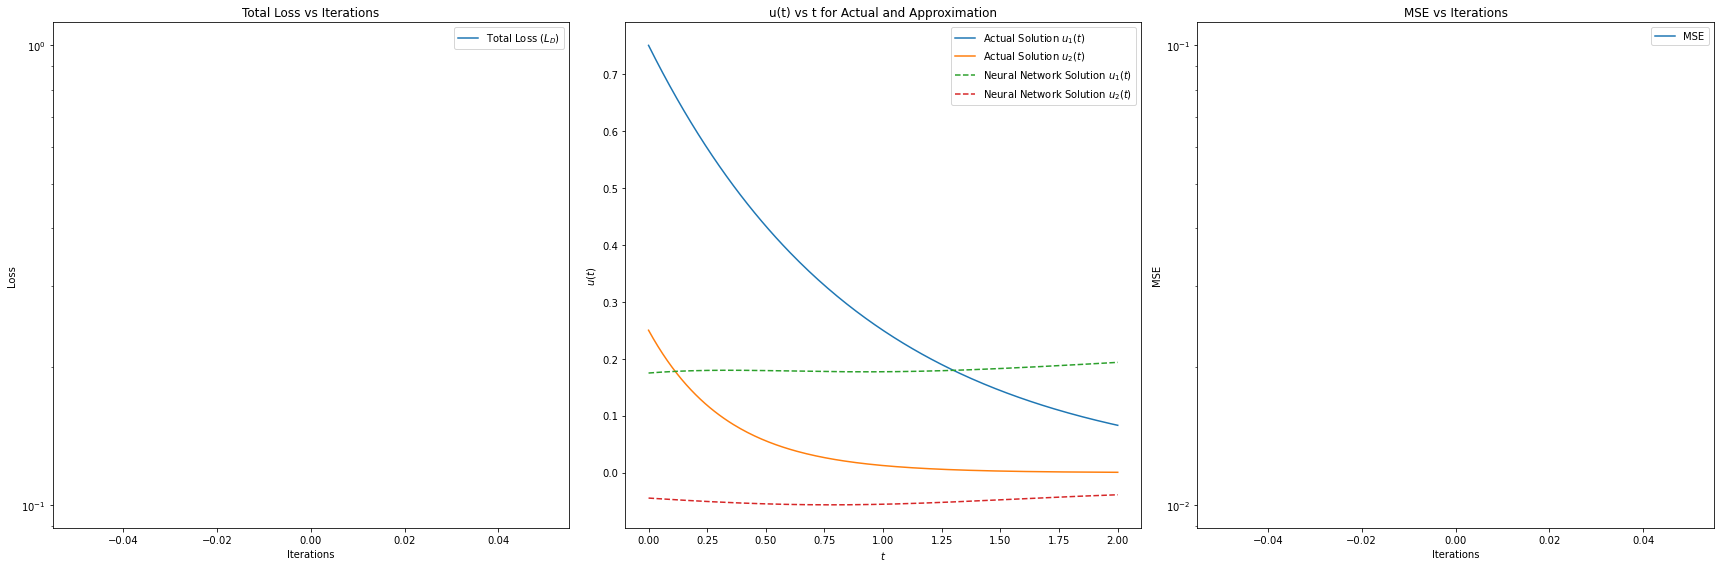

In [64]:
# run model which has two non-coupled equations
loss_hist_2_non_coup, model_2_non_coup, time_2_non_coup, MSE_2_non_coupled = run_model(iterations=iterations, 
                                                                                       x_range=x_range, 
                                                                                       A=A_non_coupled_2_eq, 
                                                                                       v_list=v_list, hid_lay=hid_lay,
                                                                                       num_equations=num_equations, 
                                                                                       true_functs=true_functs_non_coupled_2_eq)

# plot the total loss, network vs true solution and MSE for two non-coupled equations
plot_loss_mse_and_solution(x_range=x_range, true_functs=true_functs_non_coupled_2_eq, iterations=iterations, 
                           trained_model=model_2_non_coup, 
                           train_losses=loss_hist_2_non_coup['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D$)', mses=MSE_2_non_coupled)


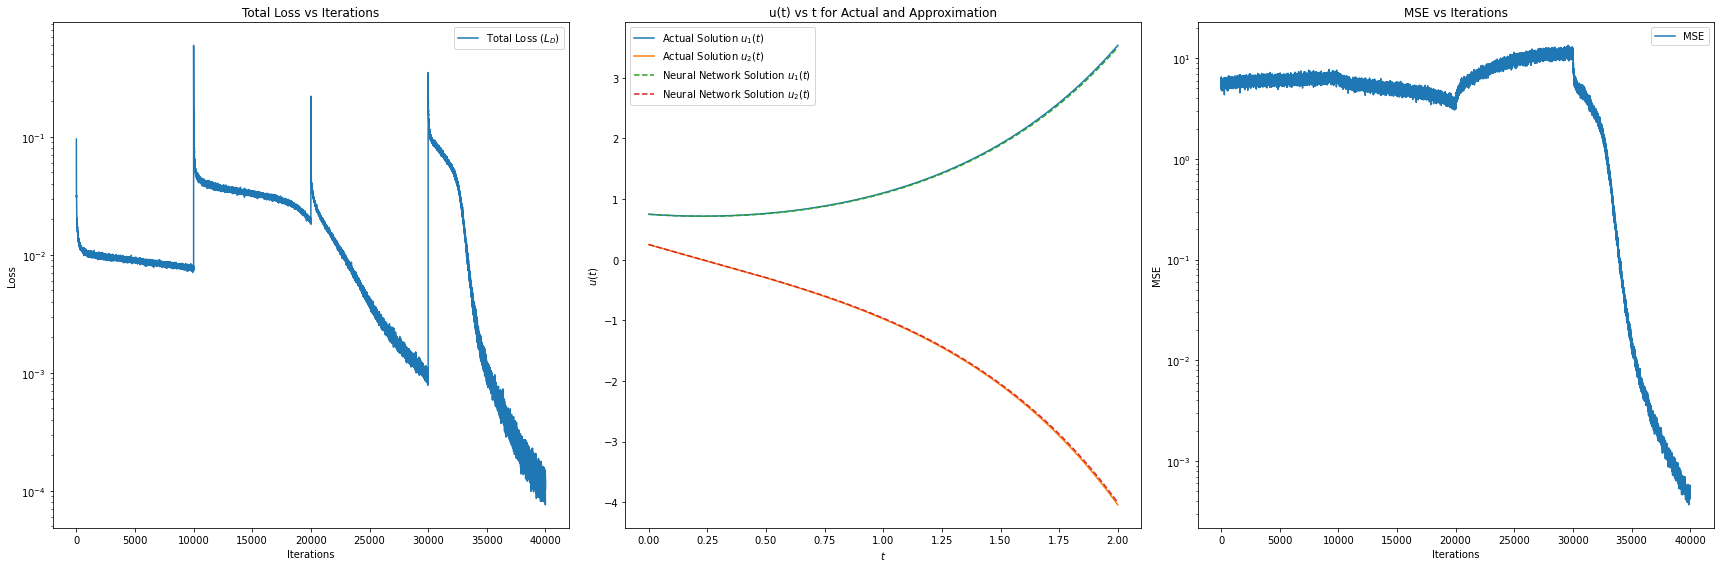

In [24]:
# run model which has two coupled equations
loss_hist_2_coup, model_2_coup, time_2_coup, MSE_2_coupled = run_model(iterations=iterations, 
                                                                       x_range=x_range, 
                                                                       A=A_coupled_2_eq, 
                                                                       v_list=v_list, hid_lay=hid_lay,
                                                                       num_equations=num_equations, 
                                                                       true_functs=true_functs_coupled_2_eq)

# plot the total loss, network vs true solution and MSE for two coupled equations
plot_loss_mse_and_solution(x_range=x_range, true_functs=true_functs_coupled_2_eq, iterations=iterations, 
                           trained_model=model_2_coup, 
                           train_losses=loss_hist_2_coup['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D$)', mses=MSE_2_coupled)

# Perform Transfer Learning

In [25]:
# generate a set of times to evaluate with
rng = np.random.default_rng()
t_eval = torch.arange(0, 2, 0.001, requires_grad=True)
t_eval = t_eval[rng.integers(low=0, high=2000, size=500)]
t_eval = t_eval.reshape(-1, 1)

# forward pass with t_eval to extract H 
output, H = model_2_coup(t_eval) 
# reshape "H" to 2 x d 
H = H.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H = torch.cat((torch.ones(len(t_eval), num_equations, 1), H), 2)

In [26]:
# compute dH_dt (note: time intensive due to large jacobian calculation)
dH_dt = torch.autograd.functional.jacobian(model_2_coup, t_eval, create_graph=True)[1].sum(axis=2)
dH_dt_new = dH_dt.reshape(-1, num_equations, hid_lay[-1] // num_equations)
dH_dt_new = torch.cat((torch.zeros(len(t_eval), num_equations, 1), dH_dt_new), 2)

In [27]:
# compute dH_dt * dH_dt.T
dH_dt_times_dH_dt_T = torch.matmul(dH_dt_new.mT, dH_dt_new)

# compute dH_dt * A * H
dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt_new.mT, A_coupled_2_eq), H)

# compute H * A.T * dH_dt
H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A_coupled_2_eq.T), dH_dt_new)

# compute H.T * A.T * A * H
H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A_coupled_2_eq.T), A_coupled_2_eq), H)

# compute the "summation portion" of the M matrix 
M_sum_terms = dH_dt_times_dH_dt_T + dH_dt_times_A_times_H + H_times_A_T_times_dH_dt + H_T_times_A_T_times_A_times_H
M_sum_terms = M_sum_terms.sum(axis=0)
M_sum_terms = M_sum_terms / len(t_eval)

# evalute model at t = 0
output_0, H_0 = model_2_coup(torch.tensor([[0.]], dtype=torch.float32, requires_grad=True))
# reshape "H" to 2 x d 
H_0 = H_0.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_0 = torch.cat((torch.ones(1, num_equations, 1), H_0), 2).squeeze()

# compute H_0.T * H_0
H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)

# compute the "M" matrix and invert it
M = M_sum_terms + H_0_T_times_H_0
M_inv = torch.linalg.pinv(M)

# compute the output weights by W_out = M ^ -1 * H_0 * u_0
W_out = torch.matmul(torch.matmul(M_inv, H_0.T), v)
print("W_out shape: ", W_out.shape)

W_out shape:  torch.Size([65, 1])


# Plot Transfer Learned Solution

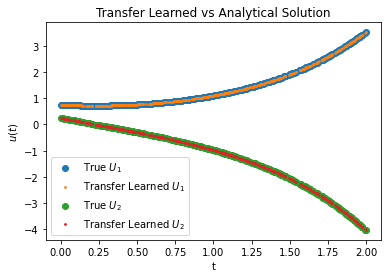

In [28]:
# compute the transfer learned solution
u_transfer = torch.matmul(H, W_out).squeeze()

# plot analytical and transfer learned solution
plt.scatter(t_eval.detach().numpy(), true_f1_coupled_2_eq(t_eval.detach().numpy()), label= 'True $U_1$');
plt.scatter(t_eval.detach().numpy(), u_transfer[:, 0].detach().numpy(), label='Transfer Learned $U_1$', s=3);
plt.scatter(t_eval.detach().numpy(), true_f2_coupled_2_eq(t_eval.detach().numpy()), label= 'True $U_2$');
plt.scatter(t_eval.detach().numpy(), u_transfer[:, 1].detach().numpy(), label='Transfer Learned $U_2$', s=3);
plt.xlabel("t")
plt.ylabel("$u(t)$")
plt.title("Transfer Learned vs Analytical Solution")
plt.legend();

# Change Initial Conditions and Do One-Shot Transfer Learning

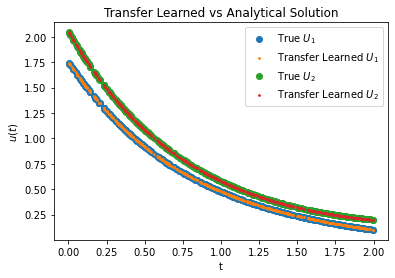

In [42]:
# v_transfer = torch.tensor([[-2.86], [20.05]])
v_transfer = torch.tensor([[1.75], [2.05]])
# true_f1_coupled_2_eq_transfer = lambda x: (0.5 * v_transfer[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v_transfer[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()
# true_f2_coupled_2_eq_transfer = lambda x: (0.5 * v_transfer[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v_transfer[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()
true_f1_coupled_2_eq_transfer = lambda x: (0.5 * v_transfer[0] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) + 1) - (0.428174 * v_transfer[1] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) - 1))).numpy()
true_f2_coupled_2_eq_transfer = lambda x: (0.5 * v_transfer[1] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) + 1) - (0.583874 * v_transfer[0] * np.exp(-1.28452 * x) * (np.exp(2.56905 * x) - 1))).numpy()

W_out_transfer = torch.matmul(torch.matmul(M_inv, H_0.T), v_transfer)
u_transfer_initial_change = torch.matmul(H, W_out_transfer).squeeze()

plt.scatter(t_eval.detach().numpy(), true_f1_coupled_2_eq_transfer(t_eval.detach().numpy()), label='True $U_1$');
plt.scatter(t_eval.detach().numpy(), u_transfer_initial_change[:, 0].detach().numpy(), label='Transfer Learned $U_1$', s=3);
plt.scatter(t_eval.detach().numpy(), true_f2_coupled_2_eq_transfer(t_eval.detach().numpy()), label='True $U_2$');
plt.scatter(t_eval.detach().numpy(), u_transfer_initial_change[:, 1].detach().numpy(), label='Transfer Learned $U_2$', s=3);
plt.xlabel("t")
plt.ylabel("$u(t)$")
plt.title("Transfer Learned vs Analytical Solution")
plt.legend();

Mean of residuals: 2.1359532183851115e-05
Initial Condition Residual: 6.33568220109737e-09


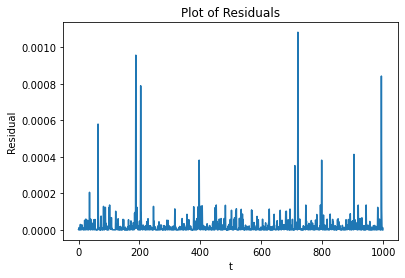

In [34]:
# compute the residuals to determine effectiveness of transfer learning when changing initial condition
residuals = ((torch.matmul(dH_dt_new, W_out_transfer) + torch.matmul(A_coupled_2_eq, torch.matmul(H, W_out_transfer))).squeeze()) ** 2
residuals = residuals.reshape(-1, 1).detach().numpy()

print(f"Mean of residuals: {residuals.mean()}")
initial_cond_residuals = ((torch.matmul(H_0, W_out_transfer) - v_transfer) ** 2).mean()
print(f"Initial Condition Residual: {initial_cond_residuals.item()}")

# plot the residuals
plt.plot(residuals);
plt.xlabel("t")
plt.ylabel("Residual")
plt.title("Plot of Residuals");

# Time One-Shot Transfer Learning

In [35]:
start_one_shot_time = time.time()
rng = np.random.default_rng(12345)
for i in range(10000):
    random_u_0 = torch.Tensor([[rng.random()], [rng.random()]])
    w_out = torch.matmul(torch.matmul(M_inv, H_0.T), random_u_0)
    
end_one_shot_time = time.time() 
total_one_shot = end_one_shot_time - start_one_shot_time
print(f"Total Time to evaluate w_out for 10000 different initial conditions: {total_one_shot: .2f} seconds")

Total Time to evaluate w_out for 10000 different initial conditions:  0.21 seconds


# Change Differential Equation ("A")  and Try One-Shot Transfer Learning

In [53]:
# new differential equation to apply training to
factor_1 = 1.43
transfer_A = torch.tensor([[0, factor_1], [factor_1, 0]])

# compute the new dH_dt * dH_dt.T using SAME dH_dt_new from previous training since it won't change
dH_dt_times_dH_dt_T_new = torch.matmul(dH_dt_new.mT, dH_dt_new)

# compute the new dH_dt * transfer_A * H using dH_dt and H from previous training since it won't change
dH_dt_times_A_times_H_new = torch.matmul(torch.matmul(dH_dt_new.mT, transfer_A), H)

# compute the new H * transfer_A.T * dH_dt using dH_dt and H from previous training since it won't change
H_times_A_T_times_dH_dt_new = torch.matmul(torch.matmul(H.mT, transfer_A.T), dH_dt_new)

# compute the new H.T * transfer_A.T * transfer_A * H
H_T_times_A_T_times_A_times_H_new = torch.matmul(torch.matmul(torch.matmul(H.mT, transfer_A.T), transfer_A), H)

# compute the new "summation portion" of the M matrix 
M_sum_terms_new = dH_dt_times_dH_dt_T_new + dH_dt_times_A_times_H_new + H_times_A_T_times_dH_dt_new + H_T_times_A_T_times_A_times_H_new
M_sum_terms_new = M_sum_terms_new.sum(axis=0)
M_sum_terms_new = M_sum_terms_new / len(t_eval)

# compute the new "M" matrix and invert it
M_new = M_sum_terms_new + H_0_T_times_H_0
M_inv_new = torch.linalg.pinv(M_new)

# compute the output weights by W_out = M ^ -1 * H_0 * u_0
W_out_new_A = torch.matmul(torch.matmul(M_inv_new, H_0.T), v)
print("W_out shape: ", W_out_new_A.shape)

W_out shape:  torch.Size([65, 1])


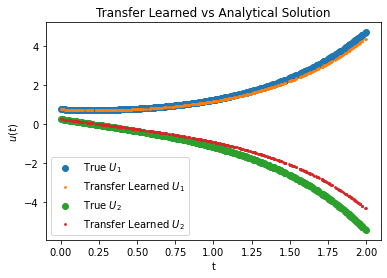

In [54]:
# true_f1_coupled_2_eq_transfer_new_A = lambda x: (0.5 * v[0] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) + 1) - (0.5 * v[1] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) - 1))).numpy()
# true_f2_coupled_2_eq_transfer_new_A = lambda x: (0.5 * v[1] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) + 1) - (0.5 * v[0] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) - 1))).numpy()
true_f1_coupled_2_eq_transfer_new_A = lambda x: (0.5 * v[0] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) + 1) - (0.428174 * v[1] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) - 1))).numpy()
true_f2_coupled_2_eq_transfer_new_A = lambda x: (0.5 * v[1] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) + 1) - (0.583874 * v[0] * np.exp(-factor_1 * x) * (np.exp(factor_1 * 2 * x) - 1))).numpy()

u_transfer_equation_change = torch.matmul(H, W_out_new_A).squeeze()

plt.scatter(t_eval.detach().numpy(), true_f1_coupled_2_eq_transfer_new_A(t_eval.detach().numpy()), label='True $U_1$');
plt.scatter(t_eval.detach().numpy(), u_transfer_equation_change[:, 0].detach().numpy(), label='Transfer Learned $U_1$', s=3);
plt.scatter(t_eval.detach().numpy(), true_f2_coupled_2_eq_transfer_new_A(t_eval.detach().numpy()), label='True $U_2$');
plt.scatter(t_eval.detach().numpy(), u_transfer_equation_change[:, 1].detach().numpy(), label='Transfer Learned $U_2$', s=3);
plt.xlabel("t")
plt.ylabel("$u(t)$")
plt.title("Transfer Learned vs Analytical Solution")
plt.legend();